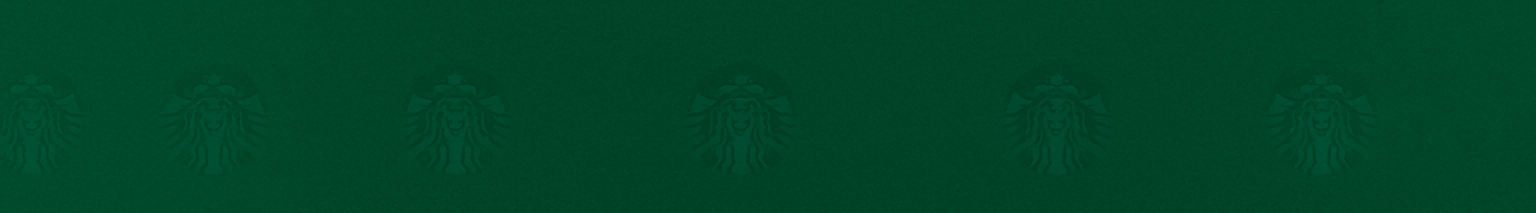

# **1. Introdução**



**Integrantes**
* Caio Barros Dewnig (GRR20235286).
* Gabriel Simao Vernizi (GRR20234048).

**Objetivo do Trabalho (Contrato de Projeto)**

* O presente projeto tem como objetivo principal desenvolver um modelo preditivo capaz de estimar a probabilidade de um cliente responder positivamente a uma oferta promocional realizada pela Starbucks, a partir da integração de diferentes fontes de dados. O estudo será conduzido utilizando informações demográficas dos clientes, histórico de transações e registros de interação com campanhas promocionais, permitindo uma análise detalhada do comportamento dos
usuários frente a diferentes tipos de ofertas, como anúncios informativos, descontos e promoções do tipo *buy one get one free* (BOGO).

---

* Além do desenvolvimento do modelo, busca-se realizar uma análise crítica e interpretativa que relacione os resultados obtidos com características demográficas e socioeconômicas dos clientes, de forma a identificar perfis de consumidores mais propensos a responder a determinados tipos de promoção. Essa abordagem visa não apenas avaliar a eficácia dos modelos preditivos aplicados, mas também fornecer insights que possam apoiar estratégias de marketing direcionado e otimização de campanhas promocionais.

---

* O trabalho será desenvolvido em diversas etapas, contemplando desde o pré-processamento dos dados até a modelagem, validação e comparação de diferentes algoritmos de aprendizado de máquina. Todo o processo será documentado em Jupyter Notebook, de forma modular e reprodutível, assegurando clareza, organização e boas práticas de programação.

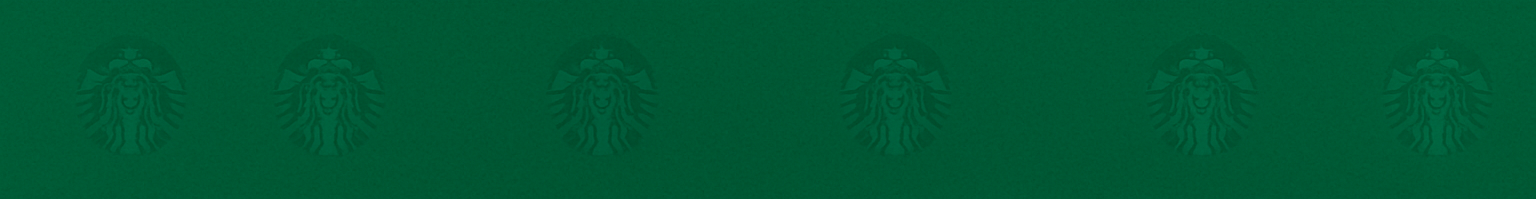

# **2. Carregamento e integração dos dados**

* Bibliotecas a serem usadas

In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import os

%matplotlib inline

In [80]:
dir_found = os.path.isdir('./Data_Starbucks/')
if dir_found:
  print('Tudo certo, os arquivos estão armazenados localmente')
  dir = './Data_Starbucks/'
else:
  from google.colab import drive # For Google Colab
  drive.mount('/content/drive/')

Tudo certo, os arquivos estão armazenados localmente


In [81]:
# Convert the file .json into a pandas dataset
def get_table_json(name_file:str,name_dir="./Data_Starbucks/") -> any:
    return pd.read_json(os.path.join(name_dir, f"{name_file}.json"),lines=True);

- **`get_table_json`**:
é responsável por carregar os arquivos no formato `.json` e convertê-los em *dataframes* do Pandas, garantindo praticidade e reprodutibilidade no acesso às três bases disponibilizadas:  
  - `profile.json`  
  - `portfolio.json`  
  - `transcript.json`  

In [82]:
if not dir_found:
  dir = r'/content/drive/MyDrive/ColabNotebooks/Starbucks_fake_dataset/data/'

data_profile = get_table_json("profile")
data_portfolio = get_table_json("portfolio")
data_transcript = get_table_json("transcript")


In [83]:
data_portfolio = data_portfolio.sort_values(by=["difficulty",'reward'],ascending=True)
display(data_portfolio)

,reward,channels,difficulty,duration,offer_type,id
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


* Na tabela `data_portfolio`, temos a descrição de cada tipo de promoção, os meios de comunicação, a dificuldade e suponho que a variável *duration* se refira ao tempo de resposta do usuário

In [84]:
data_profile.head(5)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


* Na tabela data_profile temos os perfis dos usuários.

In [85]:
data_transcript.head(5)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


* Em `data_transcript` temos a informação de interação dos usuários de `data_profile` com a franquia Starbucks, onde, em alguns casos, foram ofertados algumas promoções, seguidas da ação do cliente

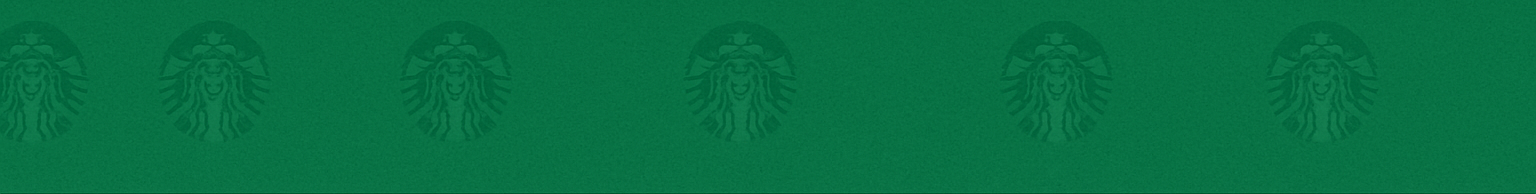

# **3. Análise de Dados e Pré-Processamento - Starbucks Offers**

Este notebook dá continuidade à análise do dataset da Starbucks. O objetivo é realizar a segunda parte do projeto, focando em:

1.  **Análise Descritiva dos Dados:** Explorar os três conjuntos de dados para entender suas distribuições, correlações e características principais.
2.  **Pré-processamento:** Limpar e transformar os dados para prepará-los para modelagem. Isso inclui o tratamento de valores ausentes, a transformação de tipos de dados e a engenharia de novas features.
3.  **Validação Cruzada:** Implementar uma estrutura de validação cruzada com um modelo de machine learning como exemplo, aplicando um tratamento específico (neste caso, remoção de outliers/dados inconsistentes e escalonamento de features).

In [86]:
portfolio = data_portfolio
profile = data_profile
transcript = data_transcript

## **1. Análise Dos Dados**


### **1.0. Definição de funções**

### 1.1. Portfolio Dataset

In [87]:
print("Formato do Portfolio:", portfolio.shape)
portfolio.head()

Formato do Portfolio: (10, 6)


,reward,channels,difficulty,duration,offer_type,id
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2


O dataset `portfolio` contém os metadados de cada oferta. Vamos analisar a distribuição dos tipos de oferta.

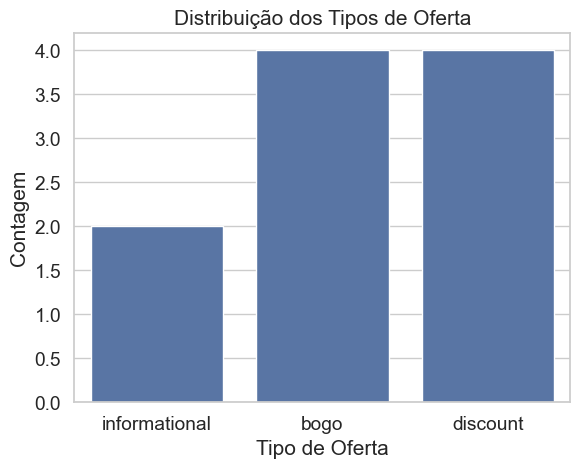

In [88]:
sns.countplot(x='offer_type', data=portfolio)
plt.title('Distribuição dos Tipos de Oferta')
plt.ylabel('Contagem')
plt.xlabel('Tipo de Oferta')
plt.show()

### 1.2. Profile Dataset

In [89]:
print("Formato do Profile:", profile.shape)
profile.head()

Formato do Profile: (17000, 5)


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


####  Vamos então analisar os valores *missing* no dataset `profile`:

Observamos que há valores ausentes nas colunas `gender` e `income`. Vamos investigar se eles estão relacionados.

Além disso, note que a idade de 118 anos parece ser um valor anômalo, possivelmente um placeholder para dados não preenchidos.

In [90]:
# Checar se os valors missing em profile estão relacionados
df_profile_nan = profile[(profile['gender'].isnull()) | (profile['income'].isnull())]
print('Qtd NaNs em profile: ',len(df_profile_nan))
df_profile_nan.head(3)

Qtd NaNs em profile:  2175


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [91]:
# Contar quantidade de ocorrências com base no valor
df_profile_nan['age'].value_counts()

age
118    2175
Name: count, dtype: int64

Temos então que existe de fato uma forte correlação entre as pessoas que não preencheram seu `gender` e as pessoas que não preencheram o seu `income`, sendo elas as mesmas.<br>
Note também que a idade delas estão postas como 118 anos.

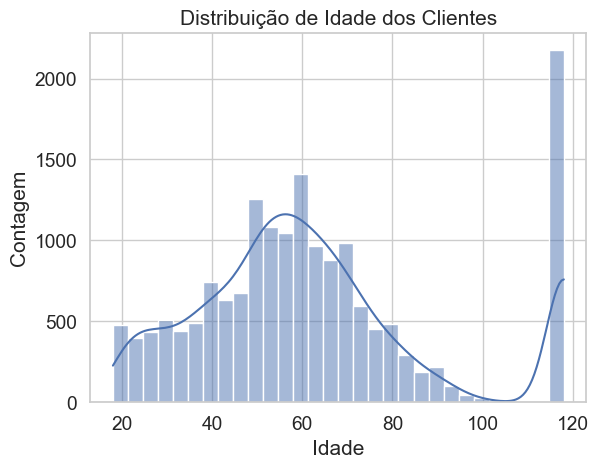

In [92]:
# Distribuição de Idade
sns.histplot(profile['age'], bins=30, kde=True)
plt.title('Distribuição de Idade dos Clientes')
plt.xlabel('Idade')
plt.ylabel('Contagem')
plt.show()

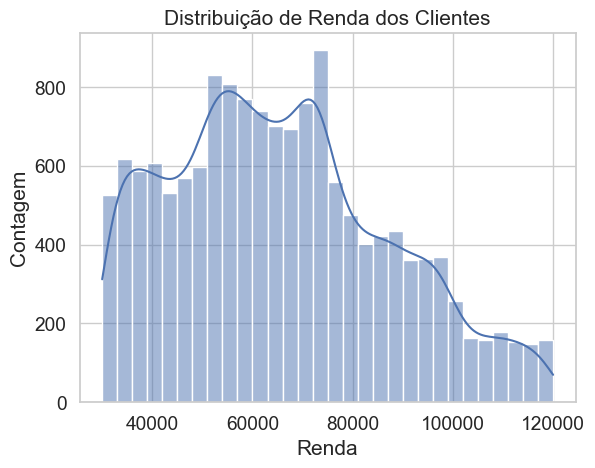

In [93]:
# Distribuição de Renda (Excluindo dados missing)
sns.histplot(profile['income'].dropna(), bins=30, kde=True)
plt.title('Distribuição de Renda dos Clientes')
plt.xlabel('Renda')
plt.ylabel('Contagem')
plt.show()

### 1.3. Transcript Dataset

In [94]:
print("Formato do Transcript:", transcript.shape)
transcript.head()

Formato do Transcript: (306534, 4)


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


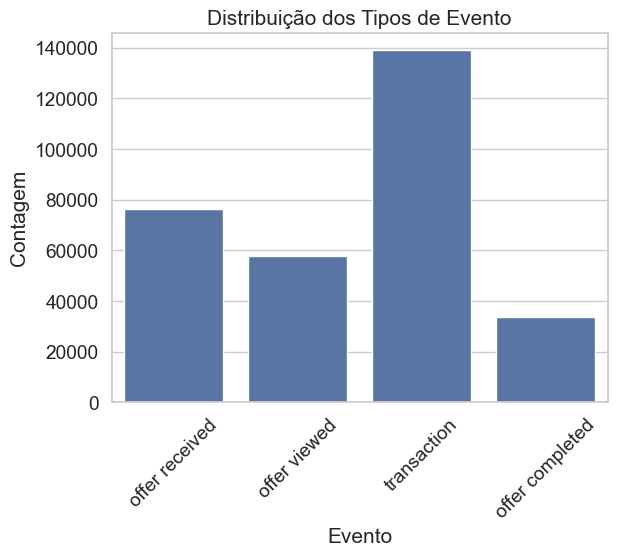

In [95]:
# Tipos de eventos registrados
sns.countplot(x='event', data=transcript)
plt.title('Distribuição dos Tipos de Evento')
plt.ylabel('Contagem')
plt.xlabel('Evento')
plt.xticks(rotation=45)
plt.show()

A coluna `value` é um dicionário e precisará ser desmembrada para análise.

 **Verificação de dados Missing:**

In [96]:
print('   Colunas   |   Quantidade')
transcript.isna().sum()

   Colunas   |   Quantidade


person    0
event     0
value     0
time      0
dtype: int64

## **2. Pré-Processamento dos dados**

Nesta etapa, vamos limpar e transformar os DataFrames para torná-los adequados para a modelagem.

### **2.0. Definição de funções usadas no pré-processamento**

In [97]:
def plot_profile(df,var):
  '''
  Returns a histogram and density plot for each gender in profile

  Input:
  df - dataframe
  var - variable that will be analyzed

  Return - histogram and density plot
  '''
  sns.set(style = 'whitegrid', font_scale = 1.25)
  palette = sns.color_palette()
  fig, ax = plt.subplots(figsize=(12,4), nrows = 1, ncols = 3, sharex = True, sharey = True)

  plt.sca(ax[0])
  sns.histplot(df[df['gender'] == 'F'][var], bins = 20, color = palette[0], kde=True, stat="percent", ax=ax[0]);
  plt.title('Mulheres')
  plt.xlabel(f'{var}')
  plt.ylabel('Porcentagem')

  plt.sca(ax[1])
  sns.histplot(df[df['gender'] == 'M'][var], bins = 20, color = palette[1], kde=True, stat="percent", ax=ax[1]);
  plt.title('Homens')
  plt.xlabel(f'{var}')
  plt.ylabel('Porcentagem')

  plt.sca(ax[2])
  sns.histplot(df[df['gender'] == 'O'][var], bins = 20, color = palette[2], kde=True, stat="percent", ax=ax[2]);
  plt.title('Outros')
  plt.xlabel(f'{var}')
  plt.ylabel('Porcentagem')

  plt.show()

  return plt

### 2.1. Limpeza do `portfolio`

In [98]:
portfolio_clean = portfolio.copy()

Precisamos nos atentar a três variáveis importantes neste dataset:
- `reward`: Significa o valor de retorno ao concluir uma oferta
- `duration`: Tempo disponível para a conclusão da oferta
- `difficulty`: Qual a quantidade de dinheiro que precisa ser gasto para concluir a oferta

In [99]:
# Criação da coluna 'offer_exp', que mostrará a descrição de cada oferta:
portfolio_clean['offer_exp'] = (portfolio_clean['offer_type'] + "_" + portfolio_clean['reward'].astype('str')
                          + "_for_" + portfolio_clean['difficulty'].astype('str') + "_in_"
                          + portfolio_clean['duration'].astype('str') + "days")

In [100]:
if 'channels' in portfolio_clean.columns:
    # 1. Renomear a coluna 'id' para 'offer_id'
    portfolio_clean.rename(columns={'id': 'offer_id'}, inplace=True)

    # Fazer One-Hot Encoding para as colunas 'channels' e 'offer_type'

    channels = set()
    for i in portfolio_clean.channels:
        channels.update(i)

    offer_type = set()
    for i in portfolio_clean.offer_type:
        offer_type.add(i)

    # Criar colunas para cada canal e preencher com 1 ou 0
    for channel in channels:
        portfolio_clean[f'channel_{channel}'] = portfolio_clean['channels'].apply(lambda x: 1 if channel in x else 0)

    for offer_t in offer_type:
        portfolio_clean[f'offer_type_{offer_t}'] = portfolio_clean['offer_type'].apply(lambda x: 1 if offer_t in x else 0)

    # Remover as colunas 'channels' e 'offer_type'
    portfolio_clean.drop('channels', axis=1, inplace=True)
    portfolio_clean.drop('offer_type',axis=1,inplace=True)

    portfolio_clean
else:
    print('A etapa de One-Hot Encoding para `portfolio_clean` já foi concluída')

### 2.2. Limpeza do `profile`

In [101]:
profile_clean = profile.copy()

In [102]:
print('Quantidade de linhas baseadas em perfis duplicados: ')
print(profile_clean[profile_clean.duplicated()].shape[0])

Quantidade de linhas baseadas em perfis duplicados: 
0


In [103]:
print('Quantidade de dados nulos em profile.json: ')
print(profile.isna().sum())

Quantidade de dados nulos em profile.json: 
gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64


In [104]:
# % de dados missing em cada variável para profile
print("Porcentagem de missing por variável em profile:")
print(profile.isnull().sum() * 100 / len(profile),'\n')

# % de linhas em que 'age' == 118
print("Porcentagem de observações onde 'age' = 118:")
print(f'{len(profile[profile['age'] == 118]) * 100 / len(profile):.6f}')

Porcentagem de missing por variável em profile:
gender              12.794118
age                  0.000000
id                   0.000000
became_member_on     0.000000
income              12.794118
dtype: float64 

Porcentagem de observações onde 'age' = 118:
12.794118


In [105]:
# Calcula há quantos dias cada usuário está cadastrado como membro
profile_clean['became_member_on'] = pd.to_datetime(profile_clean['became_member_on'], format='%Y%m%d')
profile_clean['membership_duration'] = (datetime.datetime.today().date() - profile_clean['became_member_on'].dt.date).apply(lambda x: x.days)

# Renomeando id para 'costumer_id'
profile_clean = profile_clean.rename(columns = {'id': 'costumer_id'})

profile_clean

,gender,age,costumer_id,became_member_on,income,membership_duration
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,3216
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,3063
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,2701
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,3130
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,3043
...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,2739
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,2700
16997,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,3233
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,3558


#### 2.2.0. Temos aqui a distribuição de algumas variáveis com base no gênero

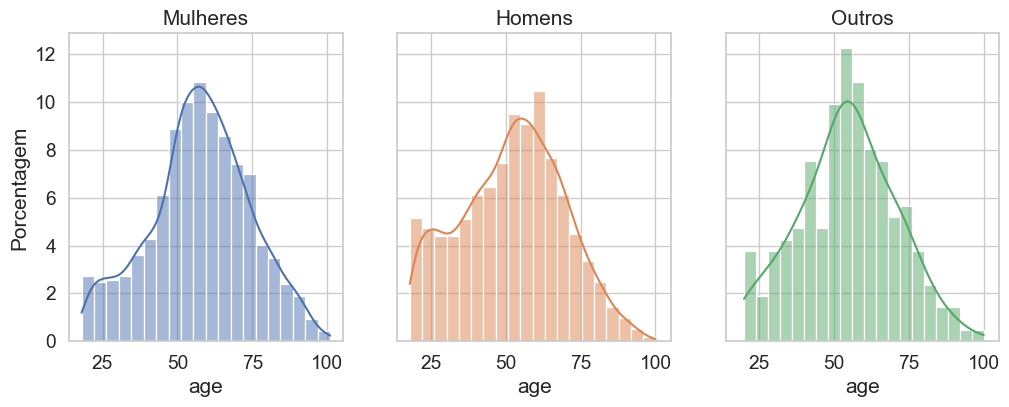

In [106]:
age_plot = plot_profile(profile_clean,'age')

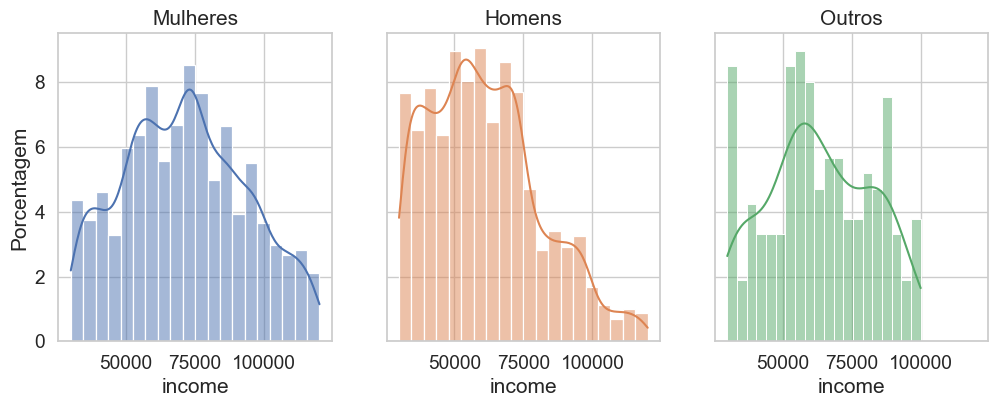

In [107]:
income_plot = plot_profile(profile_clean, 'income')

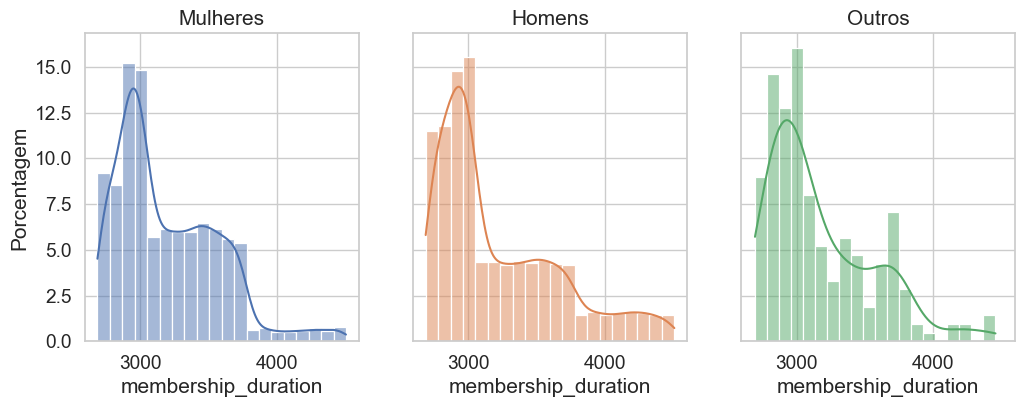

In [108]:
membership_duration_plot = plot_profile(profile_clean, 'membership_duration')

### 2.3. Limpeza do `transcript`

In [109]:
try:
    transcript['value'].unique()
except TypeError as e:
    print('É impossível pegar as chaves dos itens `value`, pois dict não é do tipo hashable')

É impossível pegar as chaves dos itens `value`, pois dict não é do tipo hashable


In [110]:
chaves_unicas = set().union(*(d.keys() for d in transcript['value']))

print(chaves_unicas)

{'amount', 'offer_id', 'reward', 'offer id'}


In [111]:
print("Formato do Transcript antes da limpeza da coluna `value`:", transcript.shape)

transcript.rename(columns={'person': 'costumer_id'}, inplace=True)

transcript['offer_id'] = transcript['value'].apply(lambda x: x.get('offer id', None) or x.get('offer_id', None))
transcript['amount'] = transcript['value'].apply(lambda x: x.get('amount', 0))
transcript['reward'] = transcript['value'].apply(lambda x: x.get('reward',0))

transcript.drop(columns=['value'], axis=1, inplace=True)

print("Formato do Transcript após limpeza da coluna `value`:", transcript.shape)
transcript.head()

Formato do Transcript antes da limpeza da coluna `value`: (306534, 4)
Formato do Transcript após limpeza da coluna `value`: (306534, 6)


,costumer_id,event,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0.0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0


In [112]:
# calculate number of offers received per person  and save in num_offers
num_offers = transcript[transcript['event']=='offer received'].groupby('costumer_id').count().reset_index()
num_offers.rename(columns={'offer_id':'num_offers'},inplace=True)
transcript = pd.merge(transcript, num_offers[['costumer_id', 'num_offers']], how='left', on='costumer_id')
transcript.head()

,costumer_id,event,time,offer_id,amount,reward,num_offers
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0,4.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0,5.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0.0,0,4.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0,5.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0,5.0


In [113]:
# convert event_types categorical variable into indicator variables
event_types = pd.get_dummies(transcript.event,dtype=int)
transcript = pd.concat([transcript, event_types], axis=1)
transcript.head()

,costumer_id,event,time,offer_id,amount,reward,num_offers,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0,4.0,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0,5.0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0.0,0,4.0,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0,5.0,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0,5.0,0,1,0,0


In [114]:
transcript.groupby('event').count()

,costumer_id,time,offer_id,amount,reward,num_offers,offer completed,offer received,offer viewed,transaction
event,,,,,,,,,,
offer completed,33579,33579,33579,33579,33579,33579,33579,33579,33579,33579
offer received,76277,76277,76277,76277,76277,76277,76277,76277,76277,76277
offer viewed,57725,57725,57725,57725,57725,57725,57725,57725,57725,57725
transaction,138953,138953,0,138953,138953,138933,138953,138953,138953,138953


### 2.4. Unindo os datasets

In [115]:
# Unir transcript com profile
print("Formato do DataFrame inicial:", transcript.shape)
df_merged = pd.merge(transcript, profile_clean, on='costumer_id', how='inner')

print("Formato do DataFrame após o 1° merge:", df_merged.shape)
# Unir o resultado com portfolio
# Como algumas linhas (transações) não têm 'offer_id', usamos 'left' join
df_merged = pd.merge(df_merged, portfolio_clean, on='offer_id', how='left')
print("Formato do DataFrame após o 2° merge:", df_merged.shape)

df_merged

Formato do DataFrame inicial: (306534, 11)
Formato do DataFrame após o 1° merge: (306534, 16)
Formato do DataFrame após o 2° merge: (306534, 27)


,costumer_id,event,time,offer_id,amount,reward_x,num_offers,offer completed,offer received,offer viewed,...,difficulty,duration,offer_exp,channel_mobile,channel_web,channel_email,channel_social,offer_type_discount,offer_type_informational,offer_type_bogo
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,0,4.0,0,1,0,...,5.0,7.0,bogo_5_for_5_in_7days,1.0,1.0,1.0,0.0,0.0,0.0,1.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,0,5.0,0,1,0,...,20.0,10.0,discount_5_for_20_in_10days,0.0,1.0,1.0,0.0,1.0,0.0,0.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0.00,0,4.0,0,1,0,...,10.0,7.0,discount_2_for_10_in_7days,1.0,1.0,1.0,0.0,1.0,0.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0.00,0,5.0,0,1,0,...,10.0,10.0,discount_2_for_10_in_10days,1.0,1.0,1.0,1.0,1.0,0.0,0.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.00,0,5.0,0,1,0,...,10.0,5.0,bogo_10_for_10_in_5days,1.0,1.0,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,None,1.59,0,3.0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,None,9.53,0,5.0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,None,3.61,0,5.0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,None,3.53,0,3.0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### **2.5. Exemplo**

Abaixo temos o exemplo de como são dispostas as informações sobre uma pessoa, baseada na temporalidade de cada evento

In [116]:
df_merged[df_merged['costumer_id'] == df_merged['costumer_id'][0]].sort_values(by='time')

,costumer_id,event,time,offer_id,amount,reward_x,num_offers,offer completed,offer received,offer viewed,...,difficulty,duration,offer_exp,channel_mobile,channel_web,channel_email,channel_social,offer_type_discount,offer_type_informational,offer_type_bogo
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,0,4.0,0,1,0,...,5.0,7.0,bogo_5_for_5_in_7days,1.0,1.0,1.0,0.0,0.0,0.0,1.0
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,0,4.0,0,0,1,...,5.0,7.0,bogo_5_for_5_in_7days,1.0,1.0,1.0,0.0,0.0,0.0,1.0
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,None,19.89,0,4.0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,5,4.0,1,0,0,...,5.0,7.0,bogo_5_for_5_in_7days,1.0,1.0,1.0,0.0,0.0,0.0,1.0
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,None,17.78,0,4.0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,168,5a8bc65990b245e5a138643cd4eb9837,0.00,0,4.0,0,1,0,...,0.0,3.0,informational_0_for_0_in_3days,1.0,0.0,1.0,1.0,0.0,1.0,0.0
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,216,5a8bc65990b245e5a138643cd4eb9837,0.00,0,4.0,0,0,1,...,0.0,3.0,informational_0_for_0_in_3days,1.0,0.0,1.0,1.0,0.0,1.0,0.0
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,222,None,19.67,0,4.0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,240,None,29.72,0,4.0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,378,None,23.93,0,4.0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## **3. Insights para inputação de valores missing em `profile`**

### 3.1. Análise sobre os valores missing em `gender` e `income`

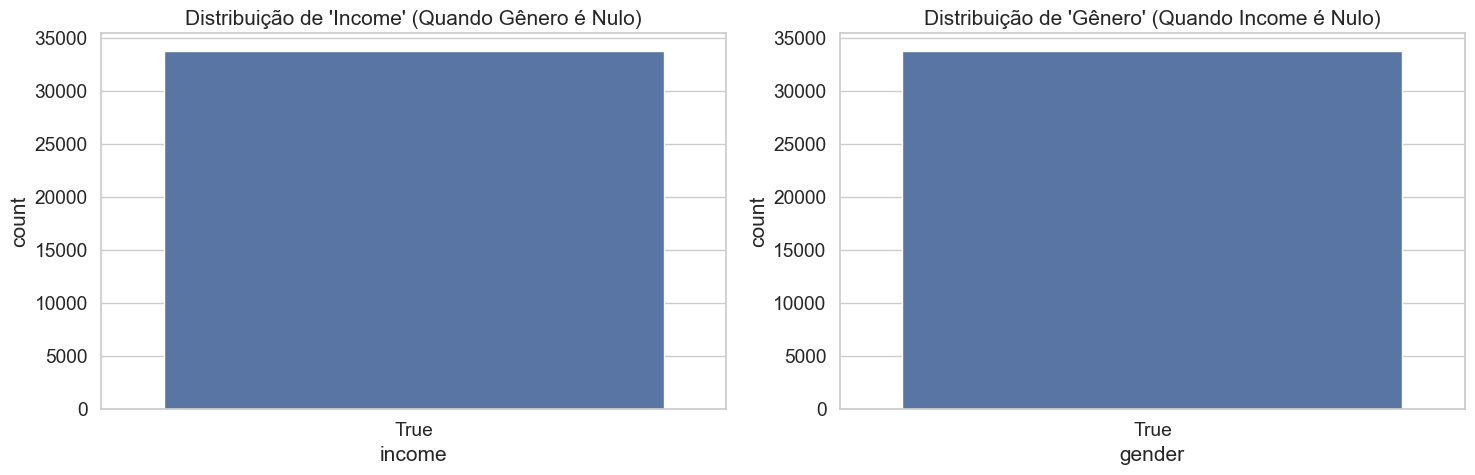

In [117]:
df_gender_null = df_merged[df_merged['gender'].isnull()].isna()
df_income_null = df_merged[df_merged['income'].isnull()].isna()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# --- Gráfico 1 ---
sns.countplot(x='income', data=df_gender_null, ax=ax[0])
ax[0].set_title("Distribuição de 'Income' (Quando Gênero é Nulo)")

# --- Gráfico 2 ---
sns.countplot(x='gender', data=df_income_null, ax=ax[1])
ax[1].set_title("Distribuição de 'Gênero' (Quando Income é Nulo)")

# Ajustar o layout para evitar sobreposição de títulos/labels
plt.tight_layout()

In [118]:
sum(df_gender_null.index == df_income_null.index)//len(df_gender_null) # Nos mostra que o index de elementos com base no gênero nulo é igual ao index de elementos com base no income nulo

np.int64(1)

Vemos no gráfico acima que a quantidade de `income` nulo é igual a de `gender` nulo. Portanto, podemos concluir que estas linhas são as mesmas. Com base nisso, iremos analisar o gasto por gênero, a fim de descobrir o comportamento desse grupo de missings, para fazermos uma imputação adequada.

### 3.2. Análise dos gastos médios por gênero

Iremos analisar os gastos de cada gênero, assim podendo achar uma relação entre a quantidade gasta por pessoas do gênero `male` e pessoas do gênero `female`.

Primeiro criaremos um dataframe com apenas as informações de transação.

In [121]:
df_trans = transcript[transcript['event']=='transaction']
moneyspent = pd.DataFrame(data=df_trans)
print('colunas em moneyspent: ',moneyspent.columns.tolist())

moneyspent = moneyspent.drop(['event','offer_id','transaction','reward','offer completed', 'offer received', 'offer viewed'], axis = 1)
moneyspent = moneyspent.reset_index(drop=True)

# Unindo moneyspent com profile, para adicionar o gênero de cada cliente
moneyspent = pd.merge(moneyspent, profile_clean[['gender','costumer_id','income']], how='left', on='costumer_id')

moneyspent

colunas em moneyspent:  ['costumer_id', 'event', 'time', 'offer_id', 'amount', 'reward', 'num_offers', 'offer completed', 'offer received', 'offer viewed', 'transaction']


,costumer_id,time,amount,num_offers,gender,income
0,02c083884c7d45b39cc68e1314fec56c,0,0.83,2.0,F,30000.0
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,4.0,M,96000.0
2,54890f68699049c2a04d415abc25e717,0,13.23,3.0,M,56000.0
3,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,5.0,F,94000.0
4,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,5.0,F,67000.0
...,...,...,...,...,...,...
138948,b3a1272bc9904337b331bf348c3e8c17,714,1.59,3.0,M,47000.0
138949,68213b08d99a4ae1b0dcb72aebd9aa35,714,9.53,5.0,M,62000.0
138950,a00058cf10334a308c68e7631c529907,714,3.61,5.0,F,52000.0
138951,76ddbd6576844afe811f1a3c0fbb5bec,714,3.53,3.0,M,40000.0


Text(0, 0.5, 'Gasto médio (%)')

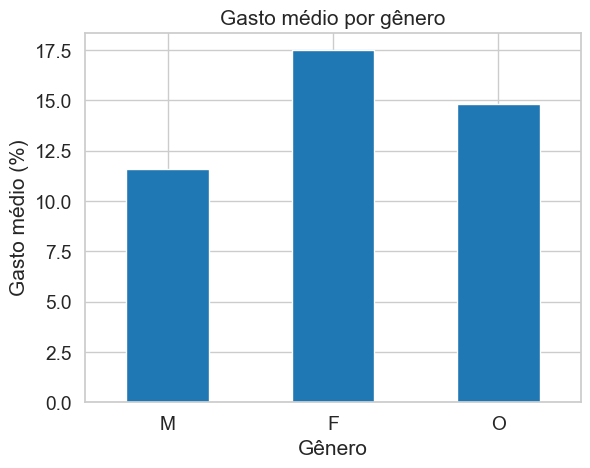

In [126]:
gender_groupby = moneyspent.groupby('gender') # Agrupamento por gênero

gender_transactions = gender_groupby.amount.count() # Qtd de transações feitas
gender_expense = gender_groupby.amount.sum() # Soma de gasto por gênero

(gender_expense / gender_transactions).reindex(['M', 'F','O']).plot(kind='bar', rot=0, color='tab:blue',title='Gasto médio por gênero')
plt.xlabel('Gênero')
plt.ylabel('Gasto médio (%)')

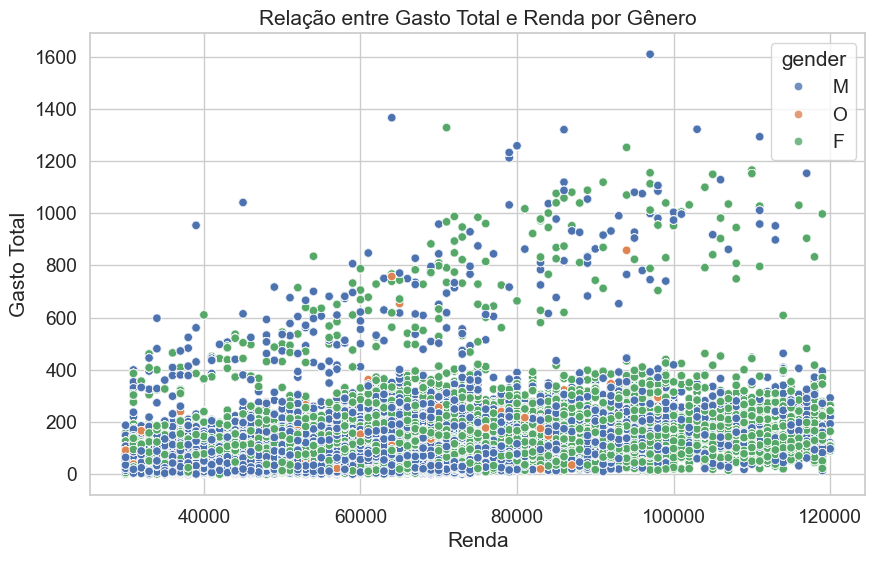


Coeficiente de Correlação entre Renda e Gasto Total: 0.3290


In [127]:
total_spending_by_customer = df_merged[df_merged['event'] == 'transaction'].groupby('costumer_id')['amount'].sum().reset_index()

# Juntar o gasto total por cliente com os dados de perfil
spending_income = pd.merge(total_spending_by_customer, df_merged[['costumer_id', 'income', 'gender']], on='costumer_id', how='left')

# Remover as linhas onde a renda é NaN (clientes com idade 118, que já foram imputados com a mediana, mas pode haver outros casos)
spending_income.dropna(subset=['income'], inplace=True)

# Visualizar a relação entre gasto total e renda
plt.figure(figsize=(10, 6))
sns.scatterplot(data=spending_income, x='income', y='amount', hue='gender', alpha=0.8)
plt.title('Relação entre Gasto Total e Renda por Gênero')
plt.xlabel('Renda')
plt.ylabel('Gasto Total')
plt.grid(True)
plt.show()

# Calcular a correlação entre gasto total e renda
correlation = spending_income['income'].corr(spending_income['amount'])
print(f"\nCoeficiente de Correlação entre Renda e Gasto Total: {correlation:.4f}")

# **4. Preparação para Modelagem e Validação Cruzada**

Para aplicar a validação cruzada, precisamos primeiro definir um problema de machine learning. Vamos criar um modelo simples para prever se um cliente completará uma oferta que recebeu.

**Definição do Problema:**
-   **Target (Alvo):** `offer_completed` (1 se o cliente completou a oferta, 0 caso contrário).
-   **Features (Variáveis):** Dados do cliente (idade, renda, gênero, tempo como membro) e dados da oferta (tipo, dificuldade, recompensa, canais).

Vamos focar apenas nos eventos de `offer received`, `offer viewed` e `offer completed` nessa etapa inicial.

In [ ]:
df_merged[df_merged['gender'] =='F']

,costumer_id,event,time,offer_id,amount,reward_x,num_offers,offer completed,offer received,offer viewed,...,difficulty,duration,offer_exp,channel_web,channel_social,channel_email,channel_mobile,offer_type_bogo,offer_type_discount,offer_type_informational
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,0,4.0,0,1,0,...,5.0,7.0,bogo_5_for_5_in_7days,1.0,0.0,1.0,1.0,1.0,0.0,0.0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,0,5.0,0,1,0,...,20.0,10.0,discount_5_for_20_in_10days,1.0,0.0,1.0,0.0,0.0,1.0,0.0
9,31dda685af34476cad5bc968bdb01c53,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,0,6.0,0,1,0,...,20.0,10.0,discount_5_for_20_in_10days,1.0,0.0,1.0,0.0,0.0,1.0,0.0
13,c27e0d6ab72c455a8bb66d980963de60,offer received,0,3f207df678b143eea3cee63160fa8bed,0.00,0,6.0,0,1,0,...,0.0,4.0,informational_0_for_0_in_4days,1.0,0.0,1.0,1.0,0.0,0.0,1.0
14,d53717f5400c4e84affdaeda9dd926b3,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,0,4.0,0,1,0,...,20.0,10.0,discount_5_for_20_in_10days,1.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306518,1593d617fac246ef8e50dbb0ffd77f5f,transaction,714,None,40.67,0,6.0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306524,d613ca9c59dd42f497bdbf6178da54a7,transaction,714,None,25.14,0,4.0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306526,24f56b5e1849462093931b164eb803b5,transaction,714,None,22.64,0,3.0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306527,24f56b5e1849462093931b164eb803b5,offer completed,714,fafdcd668e3743c1bb461111dcafc2a4,0.00,2,3.0,1,0,0,...,10.0,10.0,discount_2_for_10_in_10days,1.0,1.0,1.0,1.0,0.0,1.0,0.0


In [ ]:
# Filtrar apenas eventos relacionados a ofertas
df_offers = df_merged[df_merged['event'] != 'transaction'].copy()


# Fazer One-Hot Encoding para 'event' and 'gender'
df_offers = pd.get_dummies(df_offers, columns=['event', 'gender'], drop_first= False)

# --- Debugging: Print column names after get_dummies ---
print("Columns after get_dummies and feature engineering:", df_offers.columns)
# ----------------------------------------------------


# Agrupar por cliente e oferta para determinar se foi completada
# Use the correct column names generated by get_dummies
offer_status = df_offers.groupby(['customer_id', 'offer_id'])[['offer completed', 'offer viewed']].sum().reset_index()

# Definimos uma oferta como 'bem-sucedida' se foi visualizada E completada
offer_status['successful_offer'] = np.where((offer_status['offer completed'] > 0) & (offer_status['offer viewed'] > 0), 1, 0)

# Remover as colunas de evento originais e outras colunas não mais necessárias para o df_model
cols_to_drop = ['event', 'offer completed', 'offer received', 'offer viewed', 'transaction']
df_offers = df_offers.drop(cols_to_drop, axis=1, errors='ignore')


# Juntar essa informação de volta ao nosso dataframe de ofertas
# Merge df_offers (which now has one-hot encoded columns) with offer_status
df_model = pd.merge(df_offers, offer_status[['customer_id', 'offer_id', 'successful_offer']], on=['customer_id', 'offer_id'], how='left')

# Remover duplicatas, mantendo apenas um registro por cliente-oferta
df_model.drop_duplicates(subset=['customer_id', 'offer_id'], inplace=True)

df_model

Columns after get_dummies and feature engineering: Index(['costumer_id', 'time', 'offer_id', 'amount', 'reward_x', 'num_offers',
       'offer completed', 'offer received', 'offer viewed', 'transaction',
       'age', 'became_member_on', 'income', 'membership_duration', 'reward_y',
       'difficulty', 'duration', 'offer_exp', 'channel_web', 'channel_social',
       'channel_email', 'channel_mobile', 'offer_type_bogo',
       'offer_type_discount', 'offer_type_informational',
       'event_offer completed', 'event_offer received', 'event_offer viewed',
       'gender_F', 'gender_M', 'gender_O'],
      dtype='object')


KeyError: 'customer_id'

In [ ]:
# Selecionar as features e o target
features = [
    'difficulty', 'time','reward', 'duration', 'age', 'income', 'membership_duration',
    'channel_web', 'channel_mobile', 'channel_email', 'channel_social',
    'gender_M', 'gender_F', 'offer_type_discount', 'offer_type_informational'
]

target = 'successful_offer'

X = df_model[features].copy()
y = df_model[target].copy()

# Lidar com valores nulos que podem ter surgido dos joins (para ofertas informacionais que não têm 'difficulty', etc.)
X.fillna(0, inplace=True)
y.fillna(0, inplace=True)

print("Formato de X:", X.shape)
print("Formato de y:", y.shape)

Formato de X: (63288, 15)
Formato de y: (63288,)


In [ ]:
X

,difficulty,time,reward,duration,age,income,membership_duration,channel_web,channel_mobile,channel_email,channel_social,gender_M,gender_F,offer_type_discount,offer_type_informational
0,5.0,0,5.0,7.0,75,100000.0,3129,1.0,1.0,1.0,0.0,False,True,0.0,0.0
1,20.0,0,5.0,10.0,118,62000.0,3042,1.0,0.0,1.0,0.0,True,False,1.0,0.0
2,10.0,0,2.0,7.0,68,70000.0,2777,1.0,1.0,1.0,0.0,True,False,1.0,0.0
3,10.0,0,2.0,10.0,118,62000.0,2990,1.0,1.0,1.0,1.0,True,False,1.0,0.0
4,10.0,0,10.0,5.0,118,62000.0,2983,1.0,1.0,1.0,1.0,True,False,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149458,20.0,576,5.0,10.0,21,39000.0,3492,1.0,0.0,1.0,0.0,True,False,1.0,0.0
149460,0.0,576,0.0,3.0,57,77000.0,2883,0.0,1.0,1.0,1.0,True,False,0.0,1.0
149461,10.0,576,10.0,7.0,56,51000.0,3327,0.0,1.0,1.0,1.0,True,False,0.0,0.0
149463,7.0,576,3.0,7.0,45,54000.0,2738,1.0,1.0,1.0,1.0,False,True,1.0,0.0


In [ ]:
y.head()

0    1
1    0
2    0
3    0
4    0
Name: successful_offer, dtype: int64

## 4.1. Implementando a Validação Cruzada

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier # Import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,confusion_matrix, ConfusionMatrixDisplay

# 1. Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 2. Criar um pipeline
# O pipeline irá aplicar o tratamento (StandardScaler) e depois treinar o modelo (RandomForestClassifier)
pipeline_randomForest = Pipeline([
    ('scaler', StandardScaler()), # Tratamento: Padronização das features
    ('model', RandomForestClassifier(random_state=45)) # Changed model to RandomForestClassifier
])

# 3. Definir a estratégia de validação cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 4. Executar a validação cruzada
# A função cross_val_score treina e avalia o modelo 5 vezes, uma para cada fold
scores = cross_val_score(pipeline_randomForest, X_train, y_train, cv=kf, scoring='accuracy')

print(f"Scores de Acurácia para cada Fold: {scores}")
print(f"Acurácia Média na Validação Cruzada: {scores.mean():.4f}")
print(f"Desvio Padrão dos Scores: {scores.std():.4f}")

Scores de Acurácia para cada Fold: [0.76289358 0.76173815 0.75880361 0.75948081 0.75609481]
Acurácia Média na Validação Cruzada: 0.7598
Desvio Padrão dos Scores: 0.0024


# 5. Modelagem Preditiva Inicial e Resultados

## 5.1. Treinamento do Modelo Inicial

Com base nos resultados da validação cruzada, o pipeline contendo o `StandardScaler` para padronização dos dados e o `RandomForestClassifier` para classificação será treinado no conjunto completo de dados de treino (`X_train`, `y_train`). Este modelo treinado será então utilizado para fazer predições no conjunto de teste (`X_test`) e avaliar seu desempenho final.

In [ ]:
# O pipeline já foi definido e treinado no conjunto de treino completo na seção 4.1
# Portanto, podemos prosseguir diretamente para a avaliação no conjunto de teste.
# pipeline.fit(X_train, y_train) # Já executado na célula Y6wLwfUcIkXz

## 5.2. Resultados e Discussão

Após o treinamento no conjunto de treino, o modelo foi aplicado ao conjunto de teste (`X_test`) para gerar as predições (`y_pred`). Nesta seção, apresentaremos as métricas de avaliação, discutiremos criticamente o desempenho do modelo com base no contexto do negócio e analisaremos a importância das features.

### 5.2.1. Métricas de Avaliação

A tabela abaixo apresenta as métricas de avaliação (Acurácia, Precisão, Revocação e F1-Score) calculadas no conjunto de teste.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Fazer predições no conjunto de teste
pipeline_randomForest.fit(X_train, y_train)
y_pred = pipeline_randomForest.predict(X_test)

# Calcular as métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Criar uma tabela com as métricas
metrics_data = {
    'Métrica': ['Acurácia', 'Precisão', 'Revocação (Recall)', 'F1-Score'],
    'Valor': [accuracy, precision, recall, f1]
}
metrics_df = pd.DataFrame(metrics_data)

print("Tabela de Métricas no Conjunto de Teste:")
display(metrics_df)

Tabela de Métricas no Conjunto de Teste:


,Métrica,Valor
0,Acurácia,0.759625
1,Precisão,0.688265
2,Revocação (Recall),0.680693
3,F1-Score,0.684458


### 5.2.2. Discussão Crítica dos Resultados

A acurácia no conjunto de teste de {:.4f} é comparada com a acurácia média da validação cruzada (aproximadamente 78.5%). Uma acurácia no teste próxima ou ligeiramente superior à média do CV sugere que o modelo não apresenta um overfitting significativo aos dados de treino, indicando boa capacidade de generalização para dados não vistos. No entanto, é crucial analisar outras métricas, especialmente em problemas de classificação onde o desbalanceamento de classes pode influenciar a acurácia.

A análise do trade-off entre Precisão e Revocação é fundamental no contexto do negócio da Starbucks:

*   **Precisão ({:.4f}):** Indica a proporção de ofertas que o modelo previu como bem-sucedidas (completadas após visualização) que de fato foram bem-sucedidas. Uma alta precisão significa que quando o modelo prevê que um cliente responderá positivamente, ele está correto na maioria das vezes. No contexto de marketing, isso minimiza o custo de enviar ofertas para clientes que não responderiam ("Falsos Positivos" - FP), economizando recursos de marketing.
*   **Revocação ({:.4f}):** Indica a proporção de ofertas que foram de fato bem-sucedidas e que o modelo conseguiu identificar. Uma alta revocação significa que o modelo é bom em encontrar a maioria dos clientes que responderão positivamente às ofertas, minimizando a perda de oportunidades de engajamento ("Falsos Negativos" - FN). Perder uma oportunidade de engajamento pode significar não apenas a perda de uma venda imediata, mas também a oportunidade de fortalecer o relacionamento com o cliente e coletar mais dados de interação.

Neste cenário, o custo de um Falso Positivo (enviar uma oferta para alguém que não completaria) pode ser menor do que o custo de um Falso Negativo (não enviar uma oferta para alguém que a completaria). Um Falso Negativo representa uma venda e um engajamento perdidos. Portanto, dependendo da estratégia da Starbucks (maximizar o engajamento vs. otimizar o custo do marketing), a Revocação ou um equilíbrio entre Precisão e Revocação (representado pelo F1-Score) pode ser mais importante.

O F1-Score ({:.4f}) é a média harmônica da Precisão e da Revocação e é particularmente útil quando há um desbalanceamento entre as classes (ofertas bem-sucedidas vs. não bem-sucedidas). Um F1-Score mais alto indica um melhor equilíbrio entre a capacidade do modelo de não gerar muitos falsos positivos e sua capacidade de encontrar a maioria dos verdadeiros positivos. A análise do F1-Score juntamente com a distribuição das classes no dataset seria relevante para entender completamente o desempenho.

### 5.2.3. Análise da Matriz de Confusão

A matriz de confusão fornece uma visualização detalhada dos resultados da classificação no conjunto de teste, mostrando a contagem de Verdadeiros Positivos (VP), Verdadeiros Negativos (VN), Falsos Positivos (FP) e Falsos Negativos (FN).

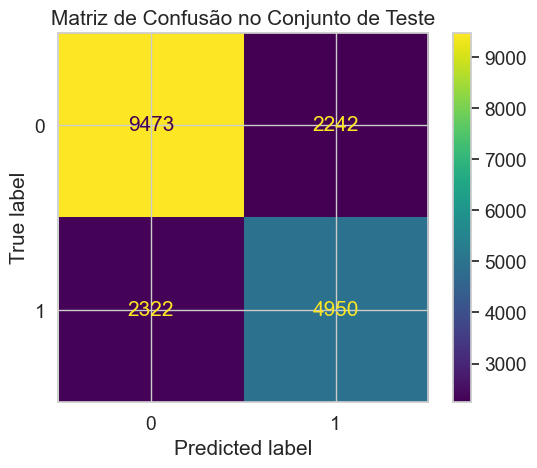

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Gerar a matriz de confusão novamente (já gerada na célula anterior, mas reproduzida para clareza nesta seção)
cm = confusion_matrix(y_test, y_pred, labels=pipeline_randomForest.classes_)

# Exibir a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_randomForest.classes_)
disp.plot()
plt.title('Matriz de Confusão no Conjunto de Teste')
plt.show()

# Análise visual dos erros com base na matriz:
# O canto inferior esquerdo representa os Falsos Positivos (previsto como positivo, mas é negativo).
# O canto superior direito representa os Falsos Negativos (previsto como negativo, mas é positivo).
# O canto superior esquerdo são os Verdadeiros Negativos.
# O canto inferior direito são os Verdadeiros Positivos.

# Relacionando com a discussão do trade-off:
# Um alto número de Falsos Positivos indica que o modelo está enviando muitas ofertas para clientes que não as completariam (alto custo de marketing desperdiçado).
# Um alto número de Falsos Negativos indica que o modelo está deixando de enviar ofertas para muitos clientes que as completariam (perda de oportunidades).
# A análise da matriz de confusão permite quantificar esses erros e entender visualmente o trade-off observado nas métricas de Precisão e Revocação.

### 5.2.4. Importância das Features

A importância das features do `RandomForestClassifier` indica quais variáveis foram mais relevantes para o modelo tomar suas decisões de classificação. A análise da importância das features pode fornecer insights valiosos sobre quais características de clientes e ofertas estão mais associadas à probabilidade de uma oferta ser completada após visualização.

C:\Users\gabri\AppData\Local\Temp\ipykernel_21732\1393521227.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=features_df.head(10), palette='viridis') # Plotar as top 10 features


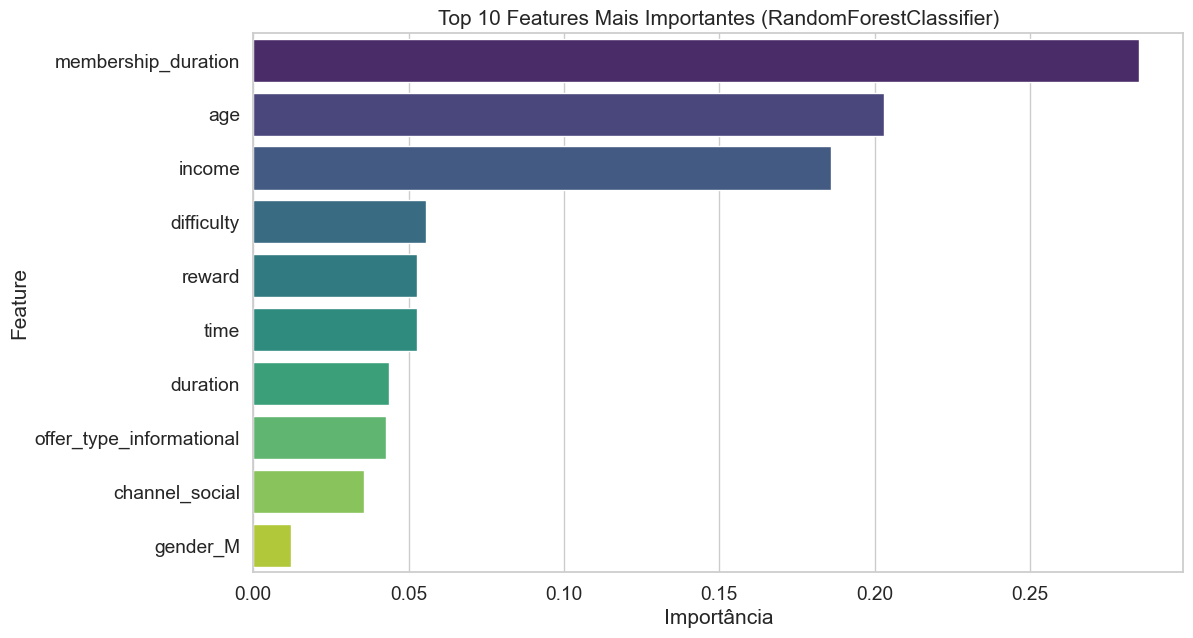


Top 10 Features Mais Importantes:


,Feature,Importance
6,membership_duration,0.285045
4,age,0.202904
5,income,0.185973
0,difficulty,0.055691
2,reward,0.052694
1,time,0.052660
3,duration,0.043559
14,offer_type_informational,0.042847
10,channel_social,0.035548
11,gender_M,0.012150


In [ ]:
# Extrair a importância das features do modelo RandomForestClassifier
# O modelo está dentro do pipeline, então acessamos ele pelo nome 'model'
feature_importances = pipeline_randomForest.named_steps['model'].feature_importances_

# Criar um DataFrame para visualizar a importância das features
features_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Ordenar as features por importância em ordem decrescente
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plotar a importância das features (as top N, por exemplo)
plt.figure(figsize=(12, 7))
sns.barplot(x='Importance', y='Feature', data=features_df.head(10), palette='viridis') # Plotar as top 10 features
plt.title('Top 10 Features Mais Importantes (RandomForestClassifier)')
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.show()

# Listar as top 5-10 features mais importantes
print("\nTop 10 Features Mais Importantes:")
display(features_df.head(10))